In [1]:
#git clone try
# Settings and Functions

import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import os

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, roc_auc_score, log_loss, roc_curve
import lightgbm as lgb

from scipy.stats import ks_2samp
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None
    
def run_lgb(train_X, train_y, val_X, val_y, text_X):
      params = {
                  "objective"  : "binary",
                  "metric"     : "binary_logloss",
                  "num_leaves" : 40,
                  "learning_rate" : 0.005,
                  "bagging_fraction" : 0.6,
                  "feature_fraction" : 0.6,
                  "bagging_frequency" : 6,
                  "bagging_seed"      : 42,
                  "verbosity"         : -1,
                  "seed" :    42
                  }
      
      lgtrain = lgb.Dataset(train_X, label=train_y)
      # lgtrain = lgb.Dataset(train_X, label_train_y, feature_name=['c1', 'c2', 'c3'], categotical_feature=['c3'])
      lgval = lgb.Dataset(val_X, label=val_y)
      evals_result = {}
      model = lgb.train(
                        params, lgtrain, 5000, 
                        valid_sets = [lgtrain, lgval], 
                        early_stopping_rounds = 100, 
                        verbose_eval=150, 
                        evals_result=evals_result
                        )
      
      pred_test_y = np.expm1(model.predict(test_X, num_iteratioin=model.best_iteration))
      return pred_test_y, model, evals_result

def ks_stat(y, yhat):
      return ks_2samp(yhat[y==1], yhat[y!=1]).statistic

### 3.1 Data Reshape

In [2]:
train_df = pd.read_csv('C:\\Users\\doris\\Documents\\Julian\\Analytics_and_Data_Science\\Python\\Titanic\\data\\train_df.csv')

X_data = train_df.drop("survived", axis=1)
Y_data = train_df["survived"]
X_array = np.asanyarray(X_data)
Y_array = np.asanyarray(Y_data)

X_train, X_test, Y_train, Y_test = train_test_split(X_array,Y_array, random_state = 666, stratify = Y_array,test_size=0.25 )

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((668, 8), (223, 8), (668,), (223,))

### 3.2 Model Selection

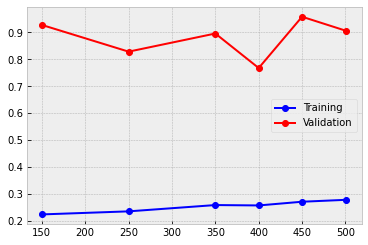

In [3]:
train_sizes, train_loss, test_loss = learning_curve(RandomForestClassifier(),X_train, Y_train, cv=4, scoring = 'neg_log_loss', train_sizes = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0])

train_loss_mean = -np.mean(train_loss,axis=1)
test_loss_mean = -np.mean(test_loss,axis=1)

plt.plot(train_sizes, train_loss_mean, 'o-', color = 'b', label = 'Training')
plt.plot(train_sizes, test_loss_mean, 'o-', color = 'r', label = 'Validation')
plt.legend(loc = 'best')
plt.show()

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_array,Y_array, random_state = None, stratify = Y_array,test_size=0.20 )

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((712, 8), (179, 8), (712,), (179,))

In [5]:
# check response rate on training and testing dataset
Y_train.mean() # train response rate
Y_test.mean()  # test response rate

0.3854748603351955

In [6]:
# Define Models

lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
gb = GradientBoostingClassifier()
xgb = xgboost.XGBClassifier()

# Fit Logistic Regression
%time lr.fit(X_train, Y_train)
acc_log = accuracy_score(Y_test,lr.predict(X_test))

# Fit SVM
%time svc.fit(X_train, Y_train)
acc_svc = accuracy_score(Y_test,svc.predict(X_test))

# Fit Random Forest
%time rf.fit(X_train, Y_train)
acc_random_forest = accuracy_score(Y_test,rf.predict(X_test))

# Fit Decision Tree
%time dt.fit(X_train, Y_train)
acc_decision_tree = accuracy_score(Y_test,dt.predict(X_test))

Wall time: 40.9 ms
Wall time: 15.9 ms
Wall time: 198 ms
Wall time: 2 ms


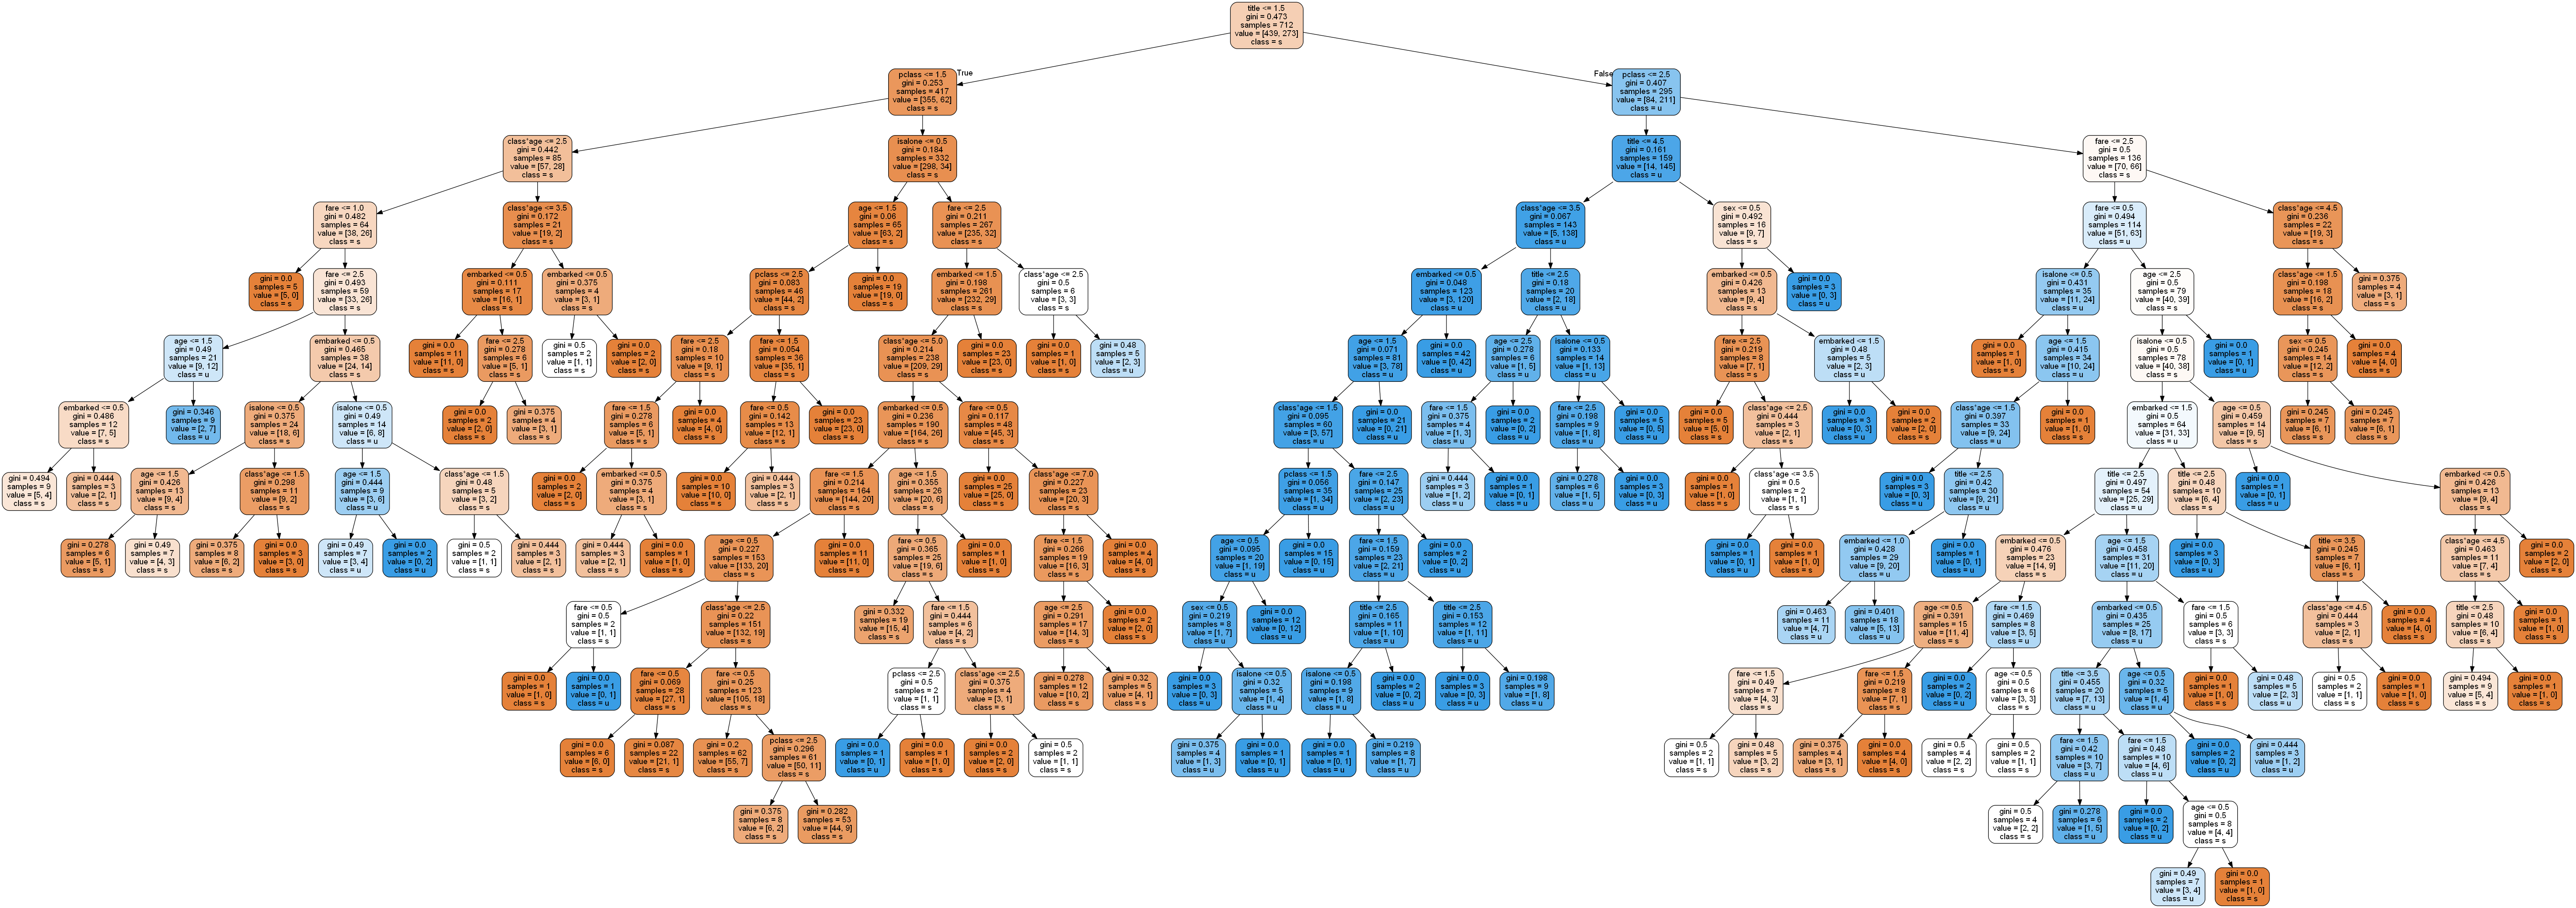

In [7]:
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dt, 
                           out_file=None, 
                           feature_names=X_data.columns,
                           class_names=Y_data.name,
                           filled=True, 
                           rounded=True
                           )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [8]:
# Fit Gradient Boosting
%time gb.fit(X_train, Y_train)
acc_gradient_boost = accuracy_score(Y_test,gb.predict(X_test))

# Fit X Gradient Boosting
%timeit xgb.fit(X_train, Y_train)
acc_xgradient_boost = accuracy_score(Y_test, xgb.predict(X_test))

Wall time: 153 ms
74.5 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# Find best model for grid search
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest','Decision Tree', 'Gradient Boosting', 'XGBM'],
    'Score': [acc_svc, acc_log, 
              acc_random_forest, acc_decision_tree, acc_gradient_boost, acc_xgradient_boost]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,0.770950
5,XGBM,0.770950
0,Support Vector Machines,0.765363
3,Decision Tree,0.759777
4,Gradient Boosting,0.759777
1,Logistic Regression,0.743017


In [10]:
#3.2.3 Random Forest Grid Search
rf_grid = {
            'n_estimators':[20, 30, 40, 50, 60, 70, 80],
            'criterion' : ['gini'],
            'max_depth' : [4, 6, 8, 10],       
            'max_features' : ['auto'],
            'random_state': [666]
            }

grid = GridSearchCV(
                    estimator = rf,
                    param_grid = rf_grid,
                    scoring = 'neg_log_loss',
                    verbose=2,
                    cv=4,
                    n_jobs = -1
                    )
                    
                    
grid.fit(X_train, Y_train)

print("*******"*15)
print(grid.best_params_)
print(grid.best_score_)
best_rf = grid.best_estimator_
acc_random_forest_grid = accuracy_score(Y_test,best_rf.predict(X_test))

Fitting 4 folds for each of 28 candidates, totalling 112 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s


*********************************************************************************************************
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 30, 'random_state': 666}
-0.40442185991992335


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    9.6s finished


In [11]:
#3.2.4 Gradient Boosting Grid Search
gb_grid = {
            'learning_rate': [0.1, 0.05],
            'n_estimators' : [20, 30, 40, 50, 60, 70, 80],
            'max_depth': [2, 4, 6, 8, 10],
            'subsample' : [0.6, 0.8, 1],
            'random_state': [666]
            }

grid = GridSearchCV(
                    estimator = gb,
                    param_grid = gb_grid,
                    scoring = 'neg_log_loss',
                    verbose=2,
                    cv=4,
                    n_jobs = -1
                    )
                    
                    
grid.fit(X_train, Y_train)

print("*******"*15)
print(grid.best_params_)
print(grid.best_score_)
best_gb = grid.best_estimator_
acc_gradient_boost_grid = accuracy_score(Y_test,best_gb.predict(X_test))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 210 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 721 tasks      | elapsed:   43.7s


*********************************************************************************************************
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 70, 'random_state': 666, 'subsample': 0.8}
-0.39973153054325433


[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   58.0s finished


In [12]:
accuracy_score(Y_train,best_gb.predict(X_train))

0.8623595505617978

In [13]:
#3.3.5 XGBM Grid Search
    
xgb_grid = {
            'learning_rate': [0.1, 0.05],
            'n_estimators' : [20, 30, 40, 50, 60, 70, 80],
            'max_depth' : [2, 4, 6, 8, 10],       
            'random_state': [666]
            
            }

grid = GridSearchCV(
                    estimator = xgb,
                    param_grid = xgb_grid,
                    scoring = 'neg_log_loss',
                    verbose=2,
                    cv=4,
                    n_jobs = -1
                    )
                    
                    
grid.fit(X_train, Y_train)

print("*******"*15)
print(grid.best_params_)
print(grid.best_score_)
best_xgb = grid.best_estimator_
acc_xgradient_boost_grid = accuracy_score(Y_test,best_gb.predict(X_test))


Fitting 4 folds for each of 70 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s


*********************************************************************************************************
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 666}
-0.3994947172154599


[Parallel(n_jobs=-1)]: Done 273 out of 280 | elapsed:    6.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    6.7s finished


In [14]:
#3.3.6 Light GBM

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
                  "objective"  : "binary",
                  "boosting" : "gbdt",
                  "metric"     : "binary_logloss",
                  "max_leaves" : 40,
                  "learning_rate" : 0.005,
                  "bagging_fraction" : 0.6,
                  "feature_fraction" : 0.6,
                  "bagging_frequency" : 6,
                  "bagging_seed"      : 42,
                  "verbosity"         : -1,
                  "seed" :    42
                  }
    lgtrain = lgb.Dataset(train_X, label=train_y)
      # lgtrain = lgb.Dataset(train_X, label_train_y, feature_name=['c1', 'c2', 'c3'], categotical_feature=['c3'])
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(
                        params, lgtrain, 5000, 
                        valid_sets = [lgtrain, lgval], 
                        early_stopping_rounds = 100, 
                        verbose_eval=150, 
                        evals_result=evals_result
                        )
    pred_test_y = model.predict(test_X, num_iteratioin=model.best_iteration)
    pred_train_y = model.predict(train_X, num_iteratioin=model.best_iteration)

    return pred_train_y, pred_test_y, model, evals_result

Y_train_proba, Y_test_proba, lgb_fit, evals_result = run_lgb(X_train, Y_train, X_train, Y_train, X_test)

Training until validation scores don't improve for 100 rounds
[150]	training's binary_logloss: 0.480713	valid_1's binary_logloss: 0.480713
[300]	training's binary_logloss: 0.412098	valid_1's binary_logloss: 0.412098
[450]	training's binary_logloss: 0.379845	valid_1's binary_logloss: 0.379845
[600]	training's binary_logloss: 0.362118	valid_1's binary_logloss: 0.362118
[750]	training's binary_logloss: 0.350913	valid_1's binary_logloss: 0.350913
[900]	training's binary_logloss: 0.342842	valid_1's binary_logloss: 0.342842
[1050]	training's binary_logloss: 0.336686	valid_1's binary_logloss: 0.336686
[1200]	training's binary_logloss: 0.331225	valid_1's binary_logloss: 0.331225
[1350]	training's binary_logloss: 0.326886	valid_1's binary_logloss: 0.326886
[1500]	training's binary_logloss: 0.32314	valid_1's binary_logloss: 0.32314
[1650]	training's binary_logloss: 0.319885	valid_1's binary_logloss: 0.319885
[1800]	training's binary_logloss: 0.317289	valid_1's binary_logloss: 0.317289
[1950]	tra

In [15]:
lgb_Y_pred = np.array(Y_test_proba>0.5,dtype='int')
acc_light_gbm = accuracy_score(Y_test, lgb_Y_pred)

In [16]:
models_grid = pd.DataFrame({
    'Model': ['Random Forest Grid','Gradient Boosting Grid','XGBM','Light GBM'],
    'Score': [acc_random_forest_grid, acc_gradient_boost_grid,acc_xgradient_boost_grid, acc_light_gbm]})
models_grid.sort_values(by='Score', ascending=False)

,Model,Score
1,Gradient Boosting Grid,0.787709
2,XGBM,0.787709
0,Random Forest Grid,0.770950
3,Light GBM,0.770950


In [17]:
# Confusion Matrix

"""
        prdt-n  prdt-p
actl-n   tn,     fp
actl-p   fn,     tp

n, p stands for predict result; t, f stands for right or wrong of the predict result

"""
print("RF")
print(confusion_matrix(Y_test, best_rf.predict(X_test)))
print("*****"*5)
print("GB")
print(confusion_matrix(Y_test, best_gb.predict(X_test)))
print("*****"*5)
print("XGB")
print(confusion_matrix(Y_test, best_xgb.predict(X_test)))
print("*****"*5)
print("LGB")
print(confusion_matrix(Y_test, lgb_Y_pred))
print("*****"*5)

RF
[[92 18]
 [23 46]]
*************************
GB
[[92 18]
 [20 49]]
*************************
XGB
[[93 17]
 [19 50]]
*************************
LGB
[[88 22]
 [19 50]]
*************************


In [18]:
print("RF")
print(classification_report(Y_test, best_rf.predict(X_test)))
# RF
# 179 / (27+179)
#presicion = tp / (fp+tp)[predicted positive]  for all predicted positive, how many of them are actual positive?
# 179 / (94+179)
#recall = tp / (fn+tp)[actual positive]  for all actual positive, how many of them are predicted by the model correctly?
# F1_score = 2*presicion*recall / (presicion+recall)
# 2*0.87*0.66 / (0.87+0.66)
print("*****"*5)
print("GB")
print(classification_report(Y_test, best_gb.predict(X_test)))
print("*****"*5)
print("XGB")
print(classification_report(Y_test, best_xgb.predict(X_test)))
print("*****"*5)
print("LGB")
print(classification_report(Y_test, lgb_Y_pred))
print("*****"*5)

RF
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       110
           1       0.72      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179

*************************
GB
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

*************************
XGB
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg

In [19]:
# precision and recall trade off

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import  cross_val_predict


y_probas_forest = cross_val_predict(best_rf, X_test, Y_test, cv = 2, method = "predict_proba")
y_scores_forest = y_probas_forest[:,1] # score = probablity of the positive class

y_probas_boost = cross_val_predict(best_gb, X_test, Y_test, cv = 2, method = "predict_proba")
y_scores_boost = y_probas_boost[:,1] # score = probablity of the positive class

y_probas_xboost = cross_val_predict(best_xgb, X_test, Y_test, cv = 2, method = "predict_proba")
y_scores_xboost = y_probas_xboost[:,1] # score = probablity of the positive class

y_scores_lgbm =  Y_test_proba

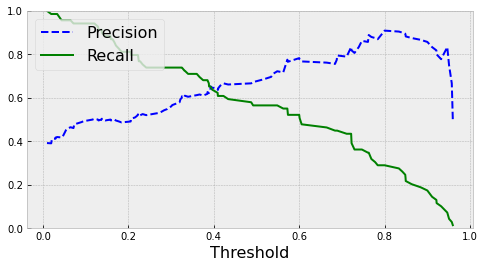

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
precisions, recalls, thresholds = precision_recall_curve(Y_test, y_scores_forest)  
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


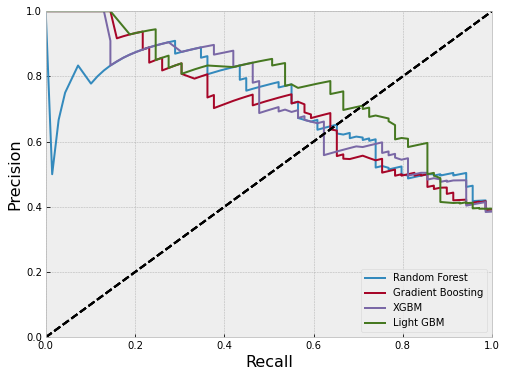

In [21]:
#P-R Curve
# P-R Curve plots the recall-precision relationship of every possible threhold from max threhold to min threhold. 
# we could select our threhold based on the proejct needs. 
# what we want is recall high and presicion also high, but the reality is when decreasing threhold, the recall is higher but the presicion is lower
#Precision and recall cannot be both very high. F1 score can measure the balance. 

def plot_precision_vs_recall(precisions, recalls, label=None):
    plt.plot(recalls, precisions, linewidth=2,label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)


plt.figure(figsize=(8, 6))

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(Y_test, y_scores_forest)  
precisions_boost, recalls_boost, thresholds_boost = precision_recall_curve(Y_test, y_scores_boost)  
precisions_xboost, recalls_xboost, thresholds_xboost = precision_recall_curve(Y_test, y_scores_xboost)  
precisions_lgbm, recalls_lgbm, thresholds_lgbm = precision_recall_curve(Y_test, y_scores_lgbm)  
plot_precision_vs_recall(precisions_forest, recalls_forest, "Random Forest")
plot_precision_vs_recall(precisions_boost, recalls_boost, "Gradient Boosting")
plot_precision_vs_recall(precisions_xboost, recalls_xboost, "XGBM")
plot_precision_vs_recall(precisions_lgbm, recalls_lgbm, "Light GBM")
plt.legend(loc="lower right")
plt.show()

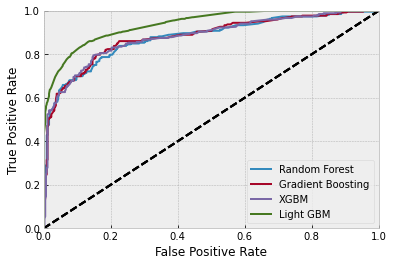

,Model,Score
3,Light GBM,0.938697
1,Gradient Boosting Grid,0.880652
2,XGBM,0.879755
0,Random Forest Grid,0.877690


In [22]:
# ROC Curves

# False positive rate measure, for all actual negative cases, how many of them (%) wrongly classified to positive 
# True positive rate measure, for all actual positve cases, how many of them (%) correcly classfied to positive
# ROC Curve plots the recall-FPR relationship of every possible threhold from max threhold to min threhold.
# what we want is recall high and FPR low, but the reality is when decreasing threhold, the recall is higher but the FPR is higher too

def plot_roc_curve(fpr, tpr, label=None):
      plt.plot(fpr, tpr, linewidth=2, label = label)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.axis([0,1,0,1])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')   

y_probas_forest = cross_val_predict(best_rf, X_train, Y_train, cv = 4, method = "predict_proba")
y_scores_forest = y_probas_forest[:,1] # score = probablity of the positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(Y_train, y_scores_forest)

y_probas_boost = cross_val_predict(best_gb, X_train, Y_train, cv = 4, method = "predict_proba")
y_scores_boost = y_probas_boost[:,1] # score = probablity of the positive class
fpr_boost, tpr_boost, threshold_boost = roc_curve(Y_train, y_scores_boost)

y_probas_xboost = cross_val_predict(best_xgb, X_train, Y_train, cv = 4, method = "predict_proba")
y_scores_xboost = y_probas_xboost[:,1] # score = probablity of the positive class
fpr_xboost, tpr_xboost, threshold_xboost = roc_curve(Y_train, y_scores_xboost)

y_scores_lgbm =  Y_train_proba
fpr_lgbm, tpr_lgbm, threshold_lgbm = roc_curve(Y_train, y_scores_lgbm)

models_auc = pd.DataFrame({
    'Model': ['Random Forest Grid','Gradient Boosting Grid','XGBM','Light GBM'],
    'Score': [roc_auc_score(Y_train, y_scores_forest), roc_auc_score(Y_train, y_scores_boost),roc_auc_score(Y_train, y_scores_xboost),
              roc_auc_score(Y_train, y_scores_lgbm)]
    })
      

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_boost, tpr_boost, "Gradient Boosting")
plot_roc_curve(fpr_xboost, tpr_xboost, "XGBM")
plot_roc_curve(fpr_lgbm, tpr_lgbm, "Light GBM")
plt.legend(loc="lower right")
plt.show()

models_auc.sort_values(by='Score', ascending=False)


In [23]:
# KS Test

def maximum_ks(str_score, str_resp, df_scored):
      """
      df_in: a dataframe that contains both group & response columns
      str_score: a string that specifies score name
      str_resp: a string that specifies response name
      """
      
      if df_scored is None:
            print("Error: no scored file for maximum_ks() !!!!")
      else:
            # Max KS
            max_ks_sort = df_scored.sort_values(str_score, ascending=False)
            max_ks_sort['response'] = df_scored[str_resp]
            max_ks_sort.index = range(1, len(max_ks_sort)+1)
            max_ks_sort['cum_good'] = max_ks_sort.response.cumsum()
            max_ks_sort['cum_bad'] = max_ks_sort.index - max_ks_sort.cum_good       
            max_ks_sort['cum_good_rate'] = max_ks_sort.cum_good / max_ks_sort.response.sum()
            max_ks_sort['cum_bad_rate'] = max_ks_sort.cum_bad / (max_ks_sort.response.size - max_ks_sort.response.sum())
            max_ks_sort['cum_rand_rate'] = max_ks_sort.index / max_ks_sort.response.size
            max_ks_sort['ks'] = max_ks_sort.cum_good_rate - max_ks_sort.cum_bad_rate
            
            max_ks_score = max_ks_sort[(max_ks_sort.ks == max_ks_sort.ks.max())]
            max_ks_score = max_ks_score[['cum_good_rate', 'cum_rand_rate', 'ks']]
            max_ks_score.rename(columns={'cum_rand_rate': 'max_ks_pop', 'ks':'max_ks'}, inplace = True)
            max_ks_score = max_ks_score.reset_index(drop = True)
            
      return max_ks_score, max_ks_sort

            
df_score_rf = pd.DataFrame({'score': best_rf.predict_proba(X_train)[:,1], 
                            'response': Y_train})            
df_score_gb = pd.DataFrame({'score': best_gb.predict_proba(X_train)[:,1], 
                            'response': Y_train})     
df_score_xgb = pd.DataFrame({'score': best_xgb.predict_proba(X_train)[:,1], 
                            'response': Y_train})     
df_score_lgb = pd.DataFrame({'score': Y_train_proba, 
                            'response': Y_train})     

ks_rf, ks_sort_rf = maximum_ks('score', 'response', df_score_rf)
ks_gb, ks_sort_gb = maximum_ks('score', 'response', df_score_gb)
ks_xgb, ks_sort_xgb = maximum_ks('score', 'response', df_score_xgb)
ks_lgb,ks_sort_lgb = maximum_ks('score', 'response', df_score_lgb)

print(ks_rf)
print("*****"*10)
print(ks_gb)
print("*****"*10)
print(ks_xgb)
print("*****"*10)
print(ks_lgb)
print("*****"*10)


   cum_good_rate  max_ks_pop    max_ks
0       0.813187    0.379213  0.703847
**************************************************
   cum_good_rate  max_ks_pop    max_ks
0       0.846154    0.407303  0.711757
**************************************************
   cum_good_rate  max_ks_pop   max_ks
0       0.827839    0.391854  0.70711
**************************************************
   cum_good_rate  max_ks_pop    max_ks
0       0.831502    0.382022  0.728996
**************************************************


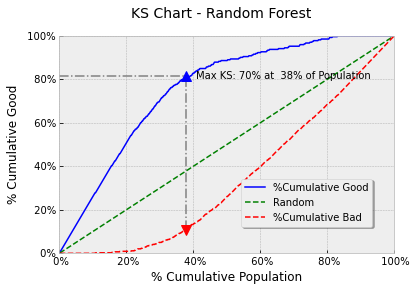

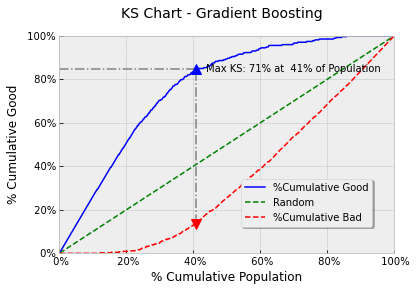

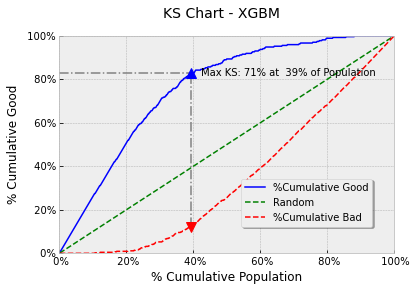

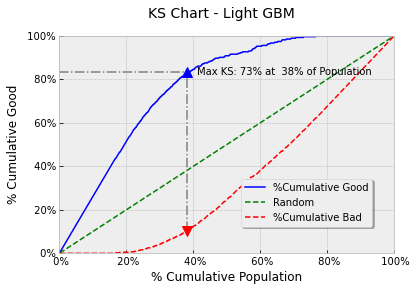

In [24]:

#KS Chart

"""
KS statistic is the maximum difference between the cumulative percentage of responders or 1's (cumulative true positive rate) 
and cumulative percentage of non-responders or 0's (cumulative false positive rate).

The significance of KS statistic is, it helps to understand, 
what portion of the population should be targeted to get the highest response rate (1's).

"""
def ks_chart(df_kstable, df_maxks, model_name):
      lorenz = pd.DataFrame({'cum_good': df_kstable.cum_good_rate.values[list(range(0, len(df_kstable)))],
                             'cum_rand': df_kstable.cum_rand_rate.values[list(range(0, len(df_kstable)))],
                             'cum_bad':  df_kstable.cum_bad_rate.values[list(range(0, len(df_kstable)))]})
      
      t0 = lorenz.cum_rand.values
      t1 = lorenz.cum_good.values
      t2 = lorenz.cum_rand.values
      t3 = lorenz.cum_bad.values
      
      fig = plt.figure()
      ax  = fig.add_subplot(111)
      
      max_ks_val = df_maxks['max_ks'].values[0]
      max_ks_pop = df_maxks['max_ks_pop'].values[0]
      max_ks_cgr = df_maxks['cum_good_rate'].values[0]      
      
      line1, = ax.plot(t0,t1,ls='solid',color='blue',lw=1.5)
      line2, = ax.plot(t0,t2,ls='dashed',color='green',lw=1.5)      
      line3, = ax.plot(t0,t3,ls='dashed',color='red',lw=1.5)            
      line4, = ax.plot(np.array([max_ks_pop,max_ks_pop]),np.array([max_ks_cgr-max_ks_val,max_ks_cgr]),ls='dashdot',color='grey',lw=1.5)
      line5, = ax.plot(np.array([0,max_ks_pop]),np.array([max_ks_cgr,max_ks_cgr]),ls='dashdot',color='grey',lw=1.5)
      mark1, = ax.plot(max_ks_pop,max_ks_cgr,marker = '^',markersize=10,color='blue')
      mark2, = ax.plot(max_ks_pop,max_ks_cgr-max_ks_val,marker = 'v',markersize=10,color='red')
      
      txt=str("Max KS:" + '{: .0%}'.format(max_ks_val) + " at " + '{: .0%}'.format(max_ks_pop) + " of Population")
      plt.text(max_ks_pop + 0.03, max_ks_cgr - 0.01, txt, ha='left', rotation=0, wrap=True)
      
      xtext = ax.set_xlabel('% Cumulative Population')
      ytext = ax.set_ylabel('% Cumulative Good')

      ax.set_xlim(0, 1.)
      ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t0, _: '{: .0%}'.format(t0)))
      ax.set_ylim(0, 1.)   
      ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda t1, _: '{: .0%}'.format(t1)))     
      
      
      plt.legend((line1, line2, line3), ('%Cumulative Good', 'Random', '%Cumulative Bad'), loc='lower right', bbox_to_anchor=[0.95,0.1], shadow=True)
      
      plt.suptitle('KS Chart - ' + model_name, fontsize=14)
      plt.show()     
      
ks_chart(ks_sort_rf, ks_rf, "Random Forest")
ks_chart(ks_sort_gb, ks_gb, "Gradient Boosting")   
ks_chart(ks_sort_xgb, ks_xgb, "XGBM")   
ks_chart(ks_sort_lgb, ks_lgb, "Light GBM")   


In [26]:
y_scores_forest = best_rf.predict_proba(X_test)[:, 1]  # score = probablity of the positive class
y_scores_boost  = best_gb.predict_proba(X_test)[:, 1]  # score = probablity of the positive class
y_scores_xboost = best_xgb.predict_proba(X_test)[:, 1]  # score = probablity of the positive class
y_scores_lgbm =  Y_test_proba

models_auc = pd.DataFrame({
    'Model': ['Random Forest Grid','Gradient Boosting Grid','XGBM','Light GBM'],
    'AUC Score': [roc_auc_score(Y_test, y_scores_forest), roc_auc_score(Y_test, y_scores_boost),roc_auc_score(Y_test, y_scores_xboost),
              roc_auc_score(Y_test, y_scores_lgbm)]
    })
 
models_auc.sort_values(by='AUC Score', ascending=False)

,Model,AUC Score
2,XGBM,0.824572
1,Gradient Boosting Grid,0.823650
0,Random Forest Grid,0.809420
3,Light GBM,0.804809


In [53]:
#transform test dataset

test_df = pd.read_csv('C:\\Users\\doris\\Documents\\Julian\\Analytics_and_Data_Science\\Python\\Titanic\\data\\test.csv').rename(columns=str.lower)

In [54]:
test_df.isnull().sum()

passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

In [55]:
#split data into numeric and character variables
var_cols = list(test_df.dtypes[test_df.dtypes == 'object'].index)
df_num = test_df.drop(var_cols, axis=1)
df_char = test_df[var_cols]

In [56]:
def fill_na_cat(data):
      df_freq = data.describe()
      for col in list(data.columns):
            if len(data[col].unique()) <= 50:
                  data[col] = data[col].fillna(data[col].mode()[0])
      return data

df_char_fillna = fill_na_cat(df_char).copy()

df_char_fillna.isnull().sum() 

def fill_na_num(data):
      df_freq = data.describe()
      for col in list(data.columns):
            if len(data[col].unique()) >= 50:
                  data[col] = data[col].fillna(data[col].median())
            else:
                  data[col] = data[col].fillna(0)
      return data      
      
df_num_fillna = fill_na_num(df_num)      

test_df = pd.concat([df_num, df_char_fillna],axis=1)
print(test_df.shape)   

(418, 11)


In [57]:
test_df['title'] = test_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(test_df['title'], test_df['sex'])

test_df['title'] = test_df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

test_df['title'] = test_df['title'].replace('Mlle', 'Miss')
test_df['title'] = test_df['title'].replace('Ms', 'Miss')
test_df['title'] = test_df['title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

test_df['title'] = test_df['title'].map(title_mapping).astype(int)
test_df['title'] = test_df['title'].fillna(0)

test_df = test_df.drop(['name'], axis=1)

test_df.head()

,passengerid,pclass,age,sibsp,parch,fare,sex,ticket,cabin,embarked,title
0,892,3,34.5,0,0,7.8292,male,330911,NaN,Q,1
1,893,3,47.0,1,0,7.0000,female,363272,NaN,S,3
2,894,2,62.0,0,0,9.6875,male,240276,NaN,Q,1
3,895,3,27.0,0,0,8.6625,male,315154,NaN,S,1
4,896,3,22.0,1,1,12.2875,female,3101298,NaN,S,3


In [58]:
guess_ages = np.zeros(5)
guess_ages

# Special Handling for Imputing missing age
for i in range(5):
            guess_df = test_df[test_df['title'] == i+1]['age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i] = int( age_guess/0.5 + 0.5 ) * 0.5 # Convert random age float to nearest .5 age

for i in range(5):
            test_df.loc[(test_df.age.isnull()) & (test_df.title == i+1) ,'age'] = guess_ages[i]

test_df['age'] = test_df['age'].astype(int)

test_df.isnull().sum() 


passengerid      0
pclass           0
age              0
sibsp            0
parch            0
fare             0
sex              0
ticket           0
cabin          327
embarked         0
title            0
dtype: int64

In [59]:
# drop passengerid cabin and ticket
test_df = test_df.drop(['passengerid', 'cabin','ticket'],axis=1)

In [60]:
test_df.loc[ test_df['age'] <= 16, 'age2'] = 0
test_df.loc[(test_df['age'] > 16) & (test_df['age'] <= 32), 'age2'] = 1
test_df.loc[(test_df['age'] > 32) & (test_df['age'] <= 48), 'age2'] = 2
test_df.loc[(test_df['age'] > 48) & (test_df['age'] <= 64), 'age2'] = 3
test_df.loc[test_df['age'] > 64, 'age2'] = 4

test_df = test_df.drop(['age'],axis=1)
test_df = test_df.rename(columns={"age2": "age"})
test_df['age'] = test_df['age'].astype(int)

test_df.loc[ test_df['fare'] <= 7.91, 'fare2'] = 0
test_df.loc[(test_df['fare'] > 7.91) & (test_df['fare'] <= 14.454), 'fare2'] = 1
test_df.loc[(test_df['fare'] > 14.454) & (test_df['fare'] <= 31), 'fare2'] = 2
test_df.loc[test_df['fare'] > 31, 'fare2'] = 3

test_df = test_df.drop(['fare'],axis=1)
test_df = test_df.rename(columns={"fare2": "fare"})
test_df['fare'] = test_df['fare'].astype(int)


test_df['familysize'] = test_df['sibsp'] + test_df['parch'] + 1

test_df.loc[test_df['familysize'] == 1, 'isalone'] = 1      
test_df.loc[test_df['familysize'] != 1, 'isalone'] = 0
test_df['isalone'] = test_df['isalone'].astype(int)

test_df = test_df.drop(['parch', 'sibsp', 'familysize'], axis=1)

In [61]:
# class*age

test_df['class*age'] = test_df['pclass']*test_df['age']   
test_df['class*age'] = test_df['class*age'].astype(int)

test_df.loc[:, ['class*age', 'age', 'pclass']].head(10)

# transform embark
test_df['embarked'] = test_df['embarked'].map( {'S': 0, 'C': 1, 'Q' : 2} ).astype(int)
# transform sex
test_df['sex'] = test_df['sex'].map( {'male': 0, 'female': 1} ).astype(int)

In [62]:
test_df.isnull().sum() 

pclass       0
sex          0
embarked     0
title        0
age          0
fare         0
isalone      0
class*age    0
dtype: int64

In [63]:
test_df.shape

(418, 8)

In [70]:
test_array = np.asanyarray(test_df)
y_test_xboost = best_xgb.predict(test_array)

In [76]:
y_test_xboost.mean()

0.3660287081339713

In [74]:
submit_df = pd.read_csv('C:\\Users\\doris\\Documents\\Julian\\Analytics_and_Data_Science\\Python\\Titanic\\data\\test.csv')
submission = pd.DataFrame({
        "PassengerId": submit_df["PassengerId"],
        "Survived": y_test_xboost
    })

In [75]:
submission.to_csv('../submission.csv', index=False)